In [1]:
import numpy as np
import pandas as pd
import math
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns
from collections import namedtuple
from matplotlib.ticker import FuncFormatter

In [3]:
[blue, green, orange, red, purple, teal] = sns.color_palette()[:6]

# Planetary Birthday Problem

_Kimberly Fessel, PhD_  &nbsp; || &nbsp; _28 December 2018_ &nbsp; || &nbsp; [Full Blog Post](https://kimfetti.github.io/mathematics/visualizations/planetary-birthday-problem/)

## Question

**_You are throwing a party and inviting random people you have never met. What's the fewest number of people you need to invite to have at least 50% probability that two strangers will have the same birthday? (Birth year need not match.)_**

## Solution

This problem can be solved by thinking about the complementary case: what is the probability that we DO NOT have two people with matching birthdays?  That would mean that each person has to have their own unique birthday.  Think about the party goers arriving at the party... the first person's birthday can be any day, but after that each new person who arrives has a more and more limited number of possible birthdays to ensure that each person's birthday is unique.  The probably that $r$ people have unique birthdays is:

$$ 1 \cdot \frac{N-1}{N} \cdot \frac{N-2}{N} \cdot \frac{N-3}{N} \cdots \frac{N-r+1}{N} = \frac{N!}{(N-r)!N^r}.$$

where $N$ is the number of days in a year ($N=365$ here on Earth) in the year and $r$ is the number of people we invite to our party.

Therefore, the probability that at least two people will have a shared birthday is just the compliment of this expression, so we are now required to find the smallest $r$ such that:

$$1 - \frac{N!}{(N-r)!N^r} > \frac{1}{2}$$

Let's build a function to help us evaluate the left-hand side of the above equation.

In [2]:
def prob_birthday_success(r, N=365):
    ''' Calculates the probability that two people will share the same birthday.
    
        Inputs:  r - the number of people considered.
                 N - the number of days in the year. Defaults to 365 days per year.
        Outputs: probability of finding two people with the same birthday.
        
        Requires r and N to be integers; requires r >= 2 and N >= 1.
        If the number of people r is bigger than the number of days N, return 1 as probability.
        Remainder of code relies on our analytic solution to arrive at answer.  
        First computes the factorial, N!/(N-r)!, and the power, N^r, before returning 
            the success probability.
    '''
    assert type(r) is int
    assert type(N) is int
    assert r >= 2
    assert N >= 1
    
    #If more people than days of year, return probability of 1.
    if r > N: return 1.
    
    factorial = reduce(lambda x, y: x*y, range(N-r+1, N+1))
    power = N**r
    return (1 - factorial/power)

Now construct list of tuples to store the number of Earth days per year for each planet.  
_(Reference: [The Orbit of the Planets. How Long Is A Year On The Other Planets?](https://www.universetoday.com/37507/years-of-the-planets/))_

In [6]:
earth_days_per_year = [
    ('Mercury', 88),
    ('Venus', 225),
    ('Earth', 365),
    ('Mars', 687),
    ('Jupiter', 4333),
    ('Saturn', 10759),
    ('Uranus', 30689),
    ('Neptune', 60182)
]

With these year lengths set, find and store the number of required party-goers for each probability of interest for each planet by utilizing the `prob_birthday_success` function.

In [8]:
# Initialize probabilities of interest and dictionary for storing results for each planet
p_success = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.999]
planet_r_success = {planet:{} for planet in [i[0] for i in earth_days_per_year]}

# Cycle through each planet
for planet, N_planet in earth_days_per_year:
    
    # Initialize r
    r = 2
    
    # For each probability of interest, increase r until probability is met 
    #    thereby finding the minimum satisfying r
    # Note that r is NOT reset since prob_birthday_success is a strictly increasing function as N increases
    for p in p_success:
        while prob_birthday_success(r, N=N_planet) < p:
            r += 1
        
        # Once r is large enough to achieve the appropriate probability, add result to planet_r_success dictionary 
        #     and move on to next probability of interest
        planet_r_success[planet][p] = r

Create dataframes to hold the days per planet year and the Birthday Problem results. Write to Excel file to be used by Tableau later.

In [24]:
df = pd.DataFrame(earth_days_per_year, columns=['planet', 'year_in_earth_days']).set_index('planet')

df = df.join(pd.DataFrame.from_dict(planet_r_success).transpose())

#df.to_excel('planetary_birthday_success_.xlsx')

## Visualizations

### Planetary Solutions

Build visualization to see what happens to the success probability on each planet as $r$ increases.

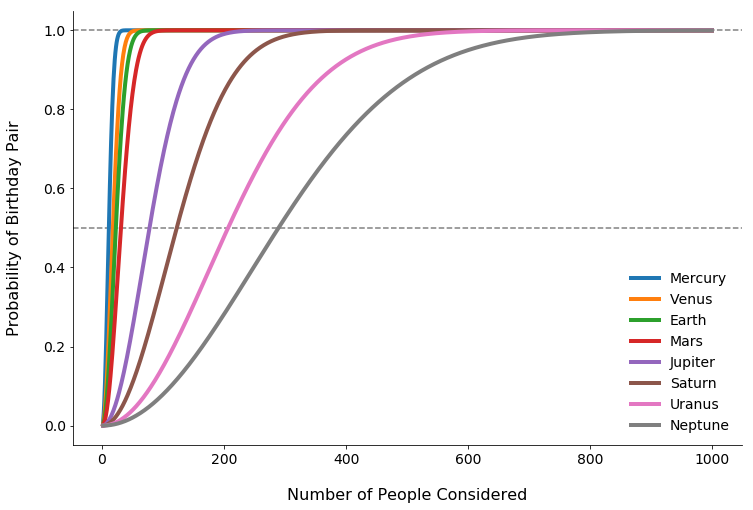

In [29]:
MAX_R = 1000

fig, ax = plt.subplots(figsize=(12,8))

for planet, N_planet in earth_days_per_year:
    plt.plot(range(2, MAX_R), [prob_birthday_success(r, N_planet) for r in range(2, MAX_R)], 
             linewidth=4, zorder=10)

plt.axhline(0.5, color='gray', linestyle='--')
plt.axhline(1, color='gray', linestyle='--')
plt.xlabel('\nNumber of People Considered', fontsize=16)
plt.ylabel('Probability of Birthday Pair\n', fontsize=16)
ax.legend([i[0] for i in earth_days_per_year], fontsize=14, frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)

### Checking Approximation

From analytic expansions, we find an approximation to relate $r$, $N$, and $p_s$; namely,

$$\frac{r(r-1)}{2N} \approx -\ln{\left(1-p_s\right)}.$$

Now build a visualization to check validity of this approximation as $N \to \infty$.

Firstly, we solve the 50% probability success for the Birthday Problem at each value of $N$.

In [38]:
# Initialize evenly sampled values of N, r, and empty list for results
N_values = range(100, 100001, 100)
r=2
r_results = []

# Solve birthday problem for given value of N for 50% probability of success
#   Note r is not reinitialized since larger values of N strictly require larger values of r
for N_val in N_values:
    while prob_birthday_success(r, N_val) < 0.5:
        r+=1
    r_results.append(r)

# Store results in dataframe
Nr_df = pd.DataFrame.from_dict({'N': N_values, 'r': r_results})

Now build a little function that will calculate the approximation based on above results.  (This is the LHS of the approximation equation above and should be roughly equivalent to $\ln(2)$.)

In [39]:
def approx_Nr(r, N):
    return r*(r-1)/(2*N)

Finally, compute approximation using `approx_Nr` and plot to compare to $\ln(2)$.  Determine how this approximation fairs as $N \to \infty$.  And overlay results for each planet in our solar system.

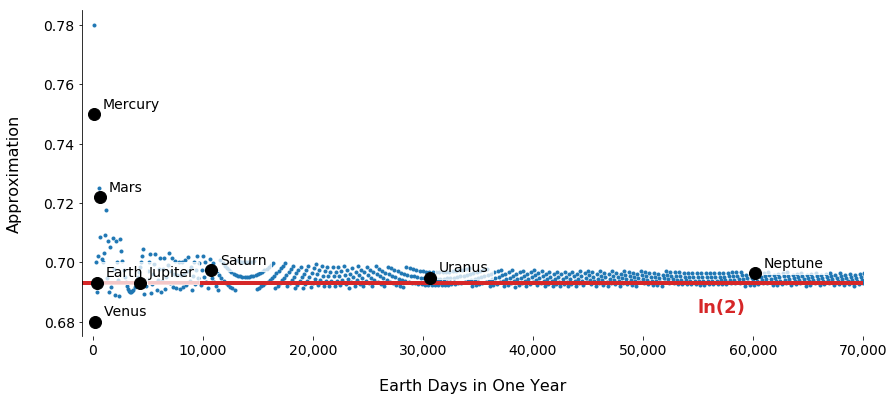

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot
plt.plot(Nr_df.N, [approx_Nr(r, N) for (r, N) in zip(Nr_df.r, Nr_df.N)], marker='o', linestyle='', markersize=3)
plt.plot(df.year_in_earth_days, ((df[0.5]*(df[0.5]-1))/(2*df.year_in_earth_days)), 
         marker='o', color='black', markersize=12, linestyle='', zorder=100)
plt.axhline(np.log(2), color=red, linewidth=4)

# Annotate
for (planet, r, N) in zip(df.index, df[0.5], df['year_in_earth_days']):
    plt.text(N+800, approx_Nr(r, N)+0.002, planet, 
             fontsize=14, 
             bbox=dict(facecolor='white', alpha=0.75, edgecolor='white'))
plt.text(55000, 0.683, 'ln(2)', 
         color=red, fontsize=18, fontweight='bold')

# Style
plt.xlim(-1000, 70000)
plt.xlabel('\nEarth Days in One Year', fontsize=16)
plt.ylabel('Approximation\n', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=14)

ax.get_xaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ',')))